In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", context="talk")

# Load Data
DATA_PATH = "../local_artifacts/processed_data/training_data.parquet"
try:
    df = pd.read_parquet(DATA_PATH)
    print(f"Loaded data shape: {df.shape}")
except FileNotFoundError:
    print(f"Data not found at {DATA_PATH}")
    df = pd.DataFrame()

if not df.empty:
    # --- Preprocessing (Matching Training Logic) ---
    
    # 1. Parse dates
    if 'arrival_time' in df.columns:
        df['arrival_time_dt'] = pd.to_datetime(df['arrival_time'])
        df['hour'] = df['arrival_time_dt'].dt.hour
    
    # 2. Impute Missing Reals
    # Preceding Train Gap & Upstream Headway: Fill with Median
    for col in ['preceding_train_gap', 'upstream_headway_14th']:
        if col in df.columns:
             df[col] = df[col].fillna(df[col].median())

    # Travel Time Deviations: Fill with 0.0
    dev_cols = [c for c in df.columns if 'deviation' in c]
    for col in dev_cols:
        df[col] = df[col].fillna(0.0)

    # Other Travel Times
    tt_cols = ['travel_time_14th', 'travel_time_34th']
    for col in tt_cols:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].median())

    # 3. Create stops_at_23rd flag
    if 'travel_time_23rd' in df.columns:
        df['stops_at_23rd'] = np.where((df['travel_time_23rd'].notna()) & (df['travel_time_23rd'] > 0), 1, 0)
        # We don't impute the value itself here as we might want to see the NaNs in EDA, 
        # but for correlation we need numbers. Let's fill with mean just for the matrix.
        valid_mean_23rd = df.loc[df['stops_at_23rd'] == 1, 'travel_time_23rd'].mean()
        df['travel_time_23rd_filled'] = df['travel_time_23rd'].fillna(valid_mean_23rd)

    print("Preprocessing complete.")
    print(df.info())

Loaded data shape: (74937, 21)
Preprocessing complete.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74937 entries, 0 to 74936
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   trip_uid                    74937 non-null  object             
 1   arrival_time                74937 non-null  object             
 2   group_id                    74937 non-null  object             
 3   route_id                    74937 non-null  object             
 4   time_idx                    74937 non-null  int64              
 5   day_of_week                 74937 non-null  int64              
 6   hour_sin                    74937 non-null  float64            
 7   hour_cos                    74937 non-null  float64            
 8   regime_id                   74937 non-null  object             
 9   track_id                    74937 non-null  object             
 10  ser

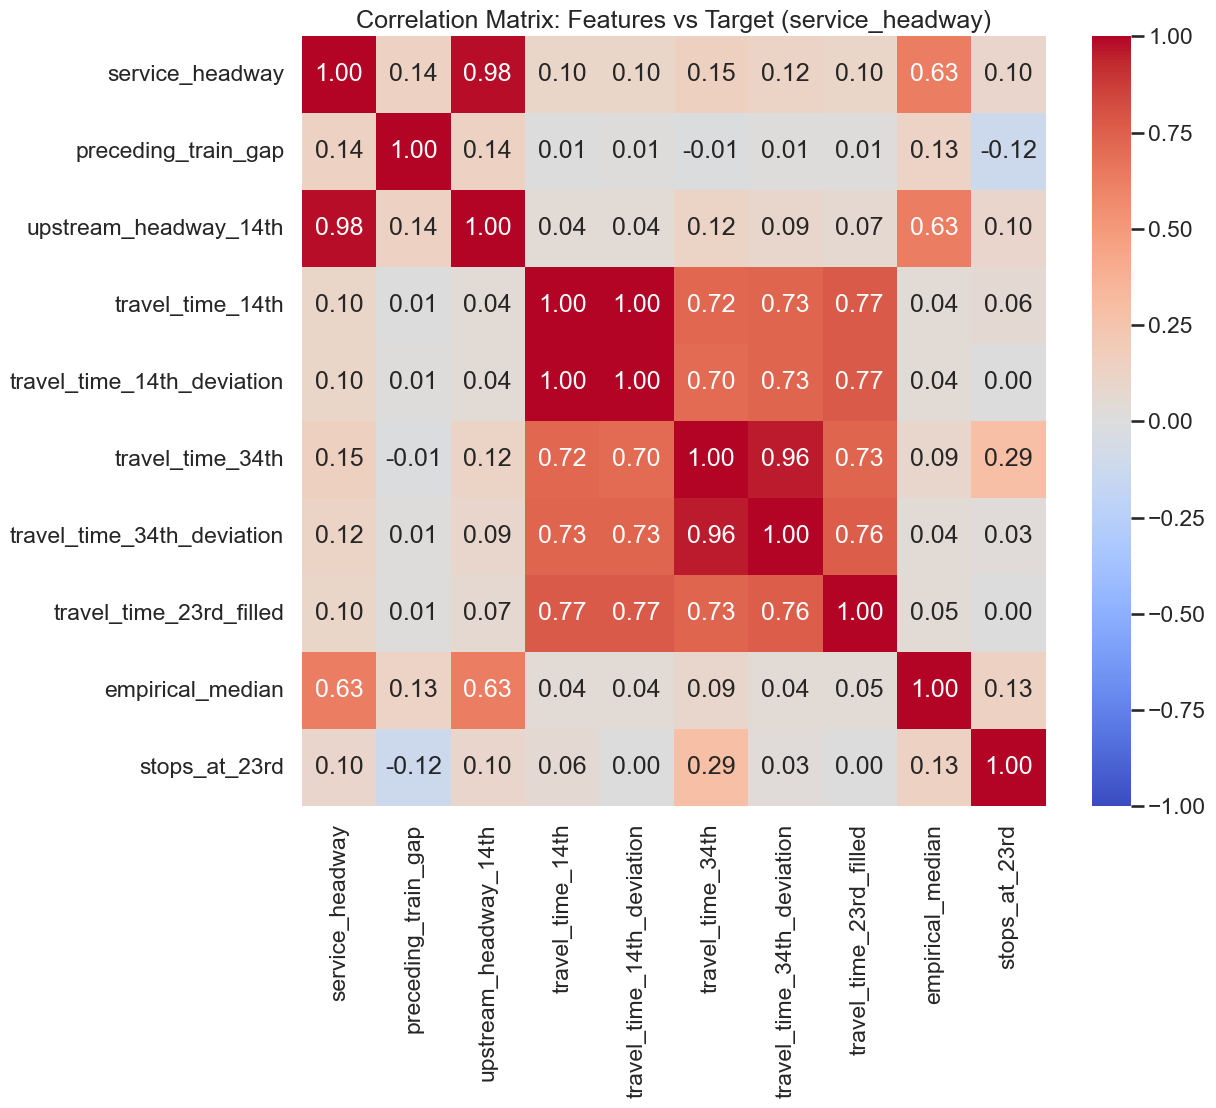

Correlations with service_headway:
service_headway               1.000000
upstream_headway_14th         0.979393
empirical_median              0.625995
travel_time_34th              0.153951
preceding_train_gap           0.137207
travel_time_34th_deviation    0.123588
travel_time_23rd_filled       0.104912
travel_time_14th              0.103830
travel_time_14th_deviation    0.102871
stops_at_23rd                 0.095770
Name: service_headway, dtype: float64


In [2]:
# --- Correlation Analysis ---
if not df.empty:
    plt.figure(figsize=(12, 10))
    
    # Select numeric columns relevant to the prediction
    # We exclude IDs and high-cardinality codes
    numeric_cols = [
        'service_headway', 
        'preceding_train_gap',
        'upstream_headway_14th',
        'travel_time_14th', 'travel_time_14th_deviation',
        'travel_time_34th', 'travel_time_34th_deviation',
        'travel_time_23rd_filled', # Used the filled version
        'empirical_median',
        'stops_at_23rd'
    ]
    
    # Filter for existing columns
    numeric_cols = [c for c in numeric_cols if c in df.columns]
    
    corr_matrix = df[numeric_cols].corr()
    
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
    plt.title("Correlation Matrix: Features vs Target (service_headway)")
    plt.show()
    
    # Print correlations with target specifically
    print("Correlations with service_headway:")
    print(corr_matrix['service_headway'].sort_values(ascending=False))

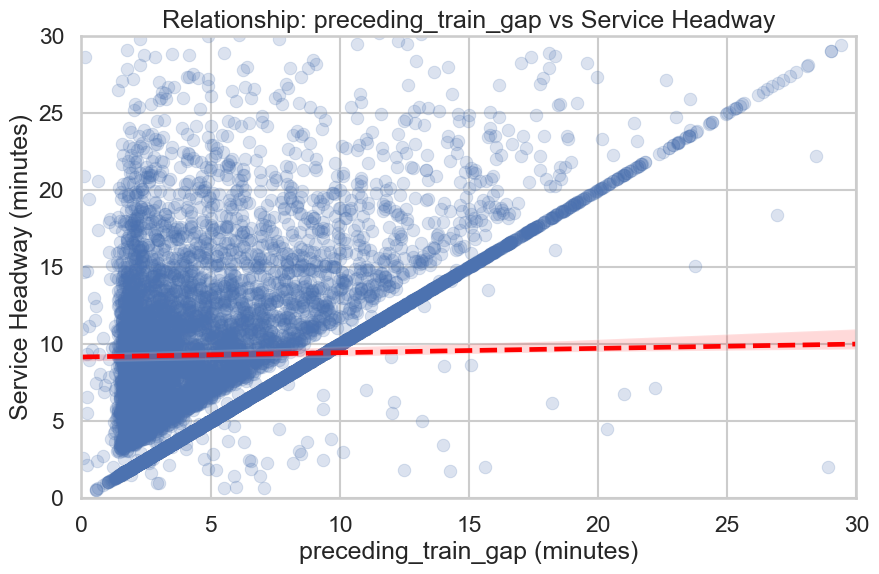

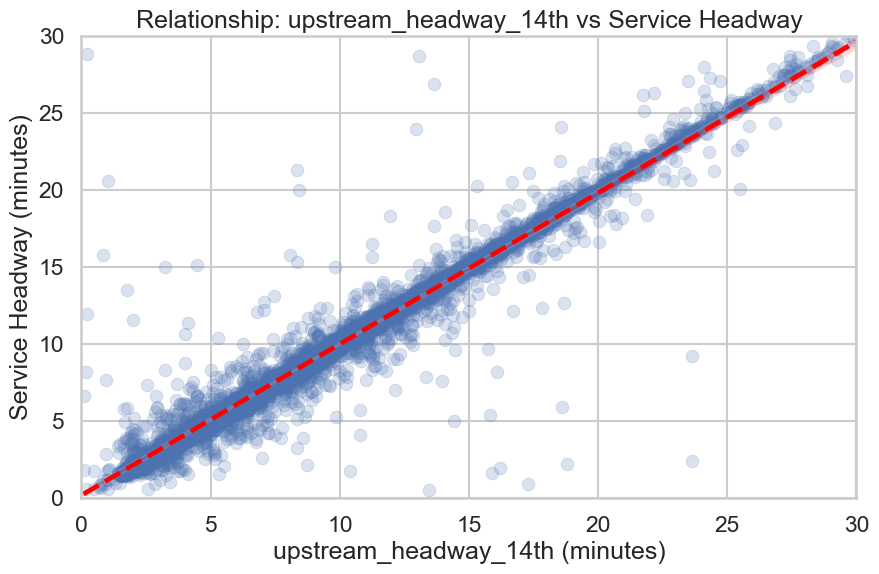

In [5]:
# --- Key Continuous Features vs Target ---
if not df.empty:
    features_to_plot = ['preceding_train_gap', 'upstream_headway_14th']
    
    for feat in features_to_plot:
        if feat in df.columns:
            plt.figure(figsize=(10, 6))
            
            # Use a sample if data is huge for performance
            plot_data = df.sample(10000) if len(df) > 10000 else df
            
            sns.scatterplot(
                data=plot_data, 
                x=feat, 
                y='service_headway', 
                alpha=0.2, 
                edgecolor=None
            )
            
            # Regression line for visual aid
            sns.regplot(
                data=plot_data, 
                x=feat, 
                y='service_headway', 
                scatter=False, 
                color='red', 
                line_kws={'linestyle':'--'}
            )
            
            plt.title(f"Relationship: {feat} vs Service Headway")
            plt.xlabel(f"{feat} (minutes)")
            plt.ylabel("Service Headway (minutes)")
            plt.xlim(0, 30) # Limit x-axis to relevant range
            plt.ylim(0, 30)
            plt.show()

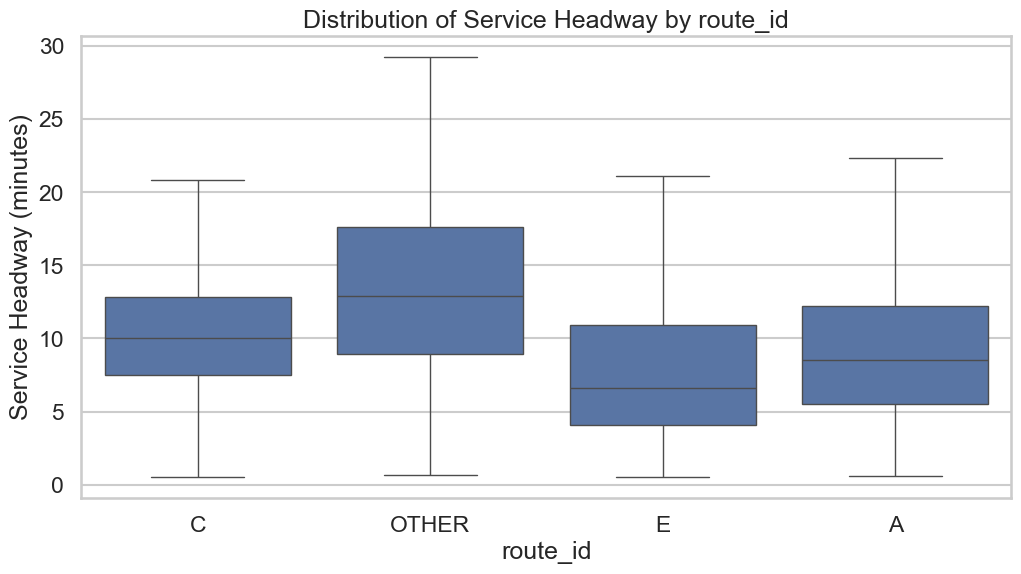

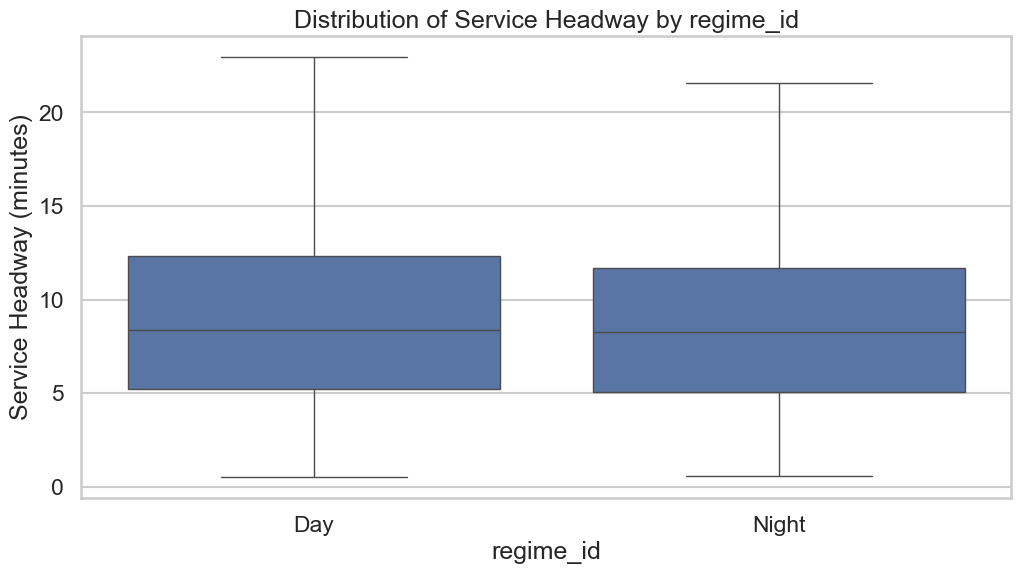

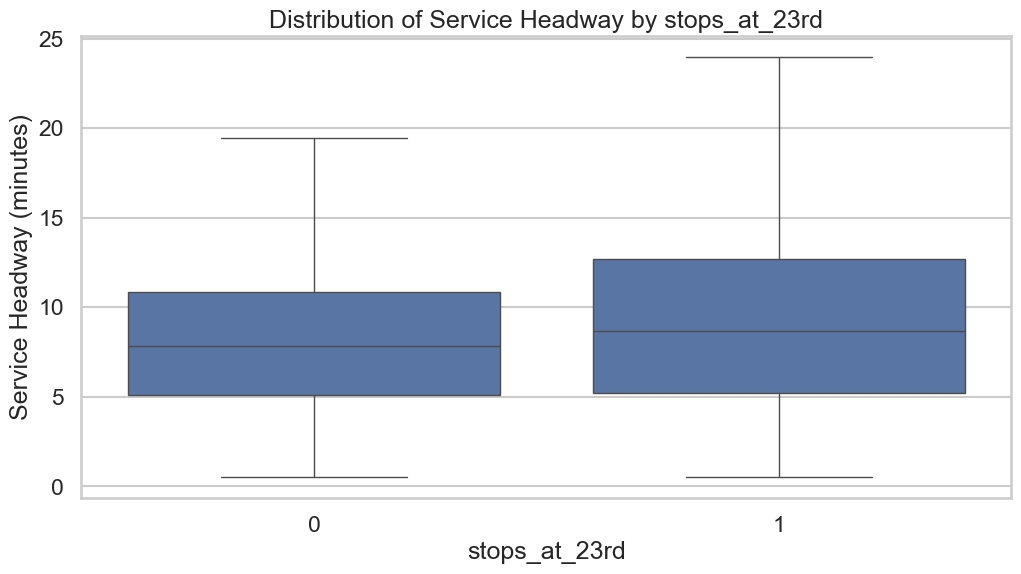

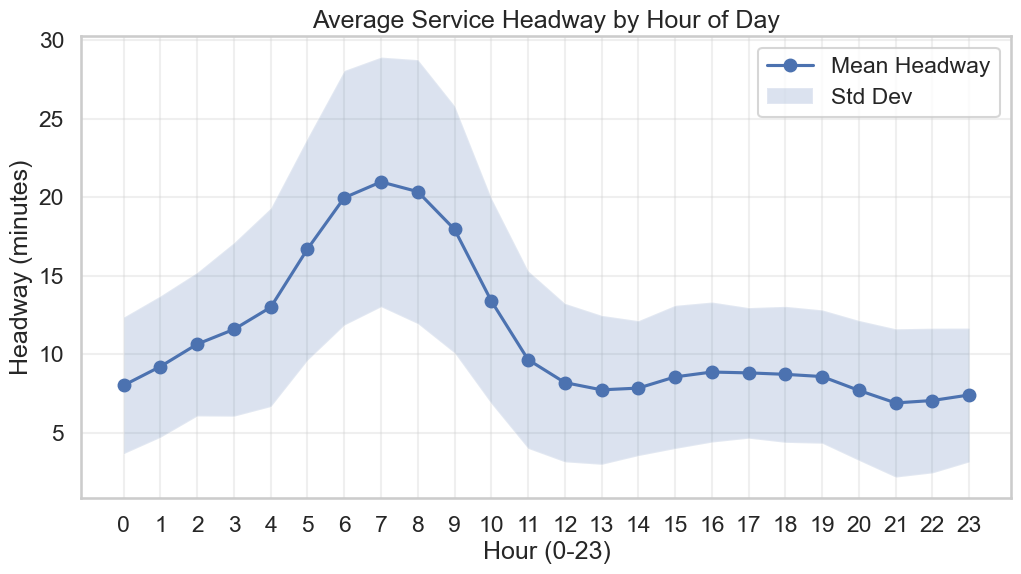

In [4]:
# --- Categorical Features vs Target ---
if not df.empty:
    cat_features = ['route_id', 'regime_id', 'stops_at_23rd']
    
    for feat in cat_features:
        if feat in df.columns:
            plt.figure(figsize=(12, 6))
            sns.boxplot(data=df, x=feat, y='service_headway', showfliers=False) # Hide outliers for clarity
            plt.title(f"Distribution of Service Headway by {feat}")
            plt.ylabel("Service Headway (minutes)")
            plt.show()

# --- Time Analysis ---
if not df.empty and 'hour' in df.columns:
    plt.figure(figsize=(12, 6))
    hourly_stats = df.groupby('hour')['service_headway'].agg(['mean', 'median', 'std']).reset_index()
    
    # Plot Mean with Error bands (Std Dev)
    plt.plot(hourly_stats['hour'], hourly_stats['mean'], label='Mean Headway', marker='o')
    plt.fill_between(
        hourly_stats['hour'], 
        hourly_stats['mean'] - hourly_stats['std'], 
        hourly_stats['mean'] + hourly_stats['std'], 
        alpha=0.2, label='Std Dev'
    )
    
    plt.title("Average Service Headway by Hour of Day")
    plt.xlabel("Hour (0-23)")
    plt.ylabel("Headway (minutes)")
    plt.xticks(range(0, 24))
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()